In [1]:
#%reset
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef
from num2words import num2words
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
import word2number
from word2number import w2n
from sklearn.tree import DecisionTreeClassifier
import pickle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import random
from matplotlib.patches import Polygon
import shap

from Functions import prep_training_test_data_period, prep_training_test_data, calculate_metrics,cross_validation_leave_geo_out, prep_training_test_data_shifted, add_labels_to_subplots, LOOCV_by_HSA_dataset, save_in_HSA_dictionary, prepare_data_and_model
hfont = {'fontname':'Helvetica'}
palette = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#e5c494']


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Load data

In [3]:
#HSA_weekly_data_all = pd.read_csv("/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_weekly.csv")
HSA_weekly_data_all = pd.read_csv("/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_weekly_incl_NA.csv")


# Global values needed for hyperparameter tuning

In [5]:
no_iterations = 100
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_period = 'exact'  # Choose 'period', 'exact', or 'shifted'
size_of_test_dataset = 1
train_weeks_for_initial_model = 1

weeks_in_future = 3 
weight_col = 'weight'  
keep_output = True  

no_iterations_param = 20  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5, 1),
    'min_samples_split': np.arange(200, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(200, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

# Polygons for mapping onto waves

In [6]:
## County Data 


data_by_county = pd.read_csv('/Users/rem76/Documents/COVID_projections/county_time_data_all_dates.csv')

data_by_county = data_by_county.dropna(subset=['admits_weekly', 'deaths_weekly', 'cases_weekly', 'icu_weekly', 'beds_weekly', 'perc_covid'])
data_by_county['CTYNAME'] = data_by_county['CTYNAME'].apply(lambda x: x.split()[0])
data_by_county['CTYNAME'] = data_by_county['fips'].astype(str) + '' + data_by_county['CTYNAME']
data_by_county['beds_over_15_100k'] = (data_by_county['beds_weekly'] > 15) * 1

# Redo dates
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i

## DELTA POLYGON 

start_date = pd.to_datetime('2021-06-30')
end_date = pd.to_datetime('2021-10-26')
data_by_county['date'] = pd.to_datetime(data_by_county['date'])
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_county.loc[data_by_county['date'] <= start_date].index.max()
matching_indices_end = data_by_county.loc[data_by_county['date'] <= end_date].index.max()
first_week_delta = data_by_county.loc[matching_indices_start, 'week']
last_week_delta = data_by_county.loc[matching_indices_end, 'week']
start_date = pd.to_datetime('2021-10-26')
end_date = pd.to_datetime('2022-09-27')
data_by_county['date'] = pd.to_datetime(data_by_county['date'])
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_county.loc[data_by_county['date'] <= start_date].index.max()
matching_indices_end = data_by_county.loc[data_by_county['date'] <= end_date].index.max()
first_week_omricon = data_by_county.loc[matching_indices_start, 'week']
last_week_omricon = data_by_county.loc[matching_indices_end, 'week']

## CDC POLYGON 
start_date = pd.to_datetime('2021-03-01')
end_date = pd.to_datetime('2022-01-24')
data_by_county['date'] = pd.to_datetime(data_by_county['date'])
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_county.loc[data_by_county['date'] <= start_date].index.max()
matching_indices_end = data_by_county.loc[data_by_county['date'] <= end_date].index.max()
first_week_CDC = data_by_county.loc[matching_indices_start, 'week']
last_week_CDC = data_by_county.loc[matching_indices_end, 'week']

Columns (47,48,49,50,51,55,56) have mixed types. Specify dtype option on import or set low_memory=False.


# Find percent exceeding capacity 

In [8]:
percent_exceed_capacity = []

# Iterate through the columns of the DataFrame
for column_name in HSA_weekly_data_all.columns:
    if 'beds_over_15_100k' in column_name:
        # Calculate the sum of the column and append it to the list
        column_sum = HSA_weekly_data_all[column_name].sum()/len(HSA_weekly_data_all[column_name])
        percent_exceed_capacity.append(column_sum)



# Naive dataset

In [9]:
columns_to_select = HSA_weekly_data_all.filter(regex="HSA|beds_over_15_100k|weight").columns.tolist()
naive_data = HSA_weekly_data_all[columns_to_select]

In [11]:

weeks_to_predict = range(1, 123 - size_of_test_dataset - 3 - train_weeks_for_initial_model)
ROC_by_week_naive_period = []
sensitivity_by_week_naive_period = []
specificity_by_week_naive_period = []
ppv_by_week_naive_period = []
npv_by_week_naive_period = []
accuracy_by_week_naive_period = []
norm_MCC_by_week_naive_period = []

ROC_by_week_naive_exact = []
sensitivity_by_week_naive_exact = []
specificity_by_week_naive_exact = []
ppv_by_week_naive_exact = []
npv_by_week_naive_exact = []
accuracy_by_week_naive_exact = []
norm_MCC_by_week_naive_exact = []

ROC_by_week_naive_shifted = []
sensitivity_by_week_naive_shifted = []
specificity_by_week_naive_shifted = []
ppv_by_week_naive_shifted = []
npv_by_week_naive_shifted = []
accuracy_by_week_naive_shifted = []
norm_MCC_by_week_naive_shifted = []


size_of_test_dataset = 1
for prediction_week in weeks_to_predict:
    print(prediction_week)
    print(range(1 , int(prediction_week + train_weeks_for_initial_model) + 1))
    print(range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1))
    #period    

    X_train_naive, y_train_naive, weights_naive, missing_data_train_HSA = prep_training_test_data(naive_data, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    

    X_test_naive, y_test_naive, weights_test_naive, missing_data_test_HSA = prep_training_test_data(naive_data, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_naive = weights_naive[0].to_numpy()
    # no hyperparameter tuning as is the same irrespective of hyperparameters
    clf_naive = DecisionTreeClassifier( random_state=10, class_weight='balanced')
    clf_naive.fit(X_train_naive, y_train_naive, sample_weight=weights_naive)

    # Make predictions on the test set
    y_pred = clf_naive.predict(X_test_naive)
    y_pred_proba = clf_naive.predict_proba(X_test_naive)

    # Evaluate the accuracy of the model
    accuracy_by_week_naive_period.append(accuracy_score(y_test_naive, y_pred))
    if len(np.unique(y_test_naive)) > 1:
    # Calculate ROC AUC score only if there are multiple classes
        ROC_by_week_naive_period.append(roc_auc_score(y_test_naive, y_pred_proba[:, 1]))
    else:
    # Set a predefined value, e.g., np.nan, when there is only one class
        ROC_by_week_naive_period.append(np.nan)    
    conf_matrix = confusion_matrix(y_test_naive, y_pred)

    sensitvity, specificity, ppv, npv = calculate_metrics(conf_matrix)
    sensitivity_by_week_naive_period.append(sensitvity)
    specificity_by_week_naive_period.append(specificity)

    ppv_by_week_naive_period.append(ppv)
    npv_by_week_naive_period.append(npv)

    norm_MCC_by_week_naive_period.append((matthews_corrcoef(y_test_naive, y_pred) + 1)/2)


    #exact 
    X_train_naive, y_train_naive, weights_naive, missing_data_train_HSA = prep_training_test_data(naive_data, no_weeks = range(1 , int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_naive, y_test_naive, weights_test_naive, missing_data_test_HSA = prep_training_test_data(naive_data, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_naive = weights_naive[0].to_numpy()
    # no hyperparameter tuning as it's the same irrespective of hyperparameters
    clf_naive = DecisionTreeClassifier(random_state=10, class_weight='balanced')
    clf_naive.fit(X_train_naive, y_train_naive, sample_weight=weights_naive)

    # Make predictions on the test set
    y_pred = clf_naive.predict(X_test_naive)
    y_pred_proba = clf_naive.predict_proba(X_test_naive)

    # Evaluate the accuracy of the model
    accuracy_by_week_naive_exact.append(accuracy_score(y_test_naive, y_pred))
    if len(np.unique(y_test_naive)) > 1:
    # Calculate ROC AUC score only if there are multiple classes
        ROC_by_week_naive_exact.append(roc_auc_score(y_test_naive, y_pred_proba[:, 1]))
    else:
    # Set a predefined value, e.g., np.nan, when there is only one class
        ROC_by_week_naive_exact.append(np.nan)
    conf_matrix = confusion_matrix(y_test_naive, y_pred)

    sensitivity, specificity, ppv, npv = calculate_metrics(conf_matrix)
    sensitivity_by_week_naive_exact.append(sensitivity)
    specificity_by_week_naive_exact.append(specificity)

    ppv_by_week_naive_exact.append(ppv)
    npv_by_week_naive_exact.append(npv)
    norm_MCC_by_week_naive_exact.append((matthews_corrcoef(y_test_naive, y_pred) + 1)/2)


    # shifted
    X_train_naive_shifted, y_train_naive_shifted, weights_naive_shifted, missing_data_train_HSA = prep_training_test_data_shifted(naive_data, no_weeks=range(1 , int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_naive_shifted, y_test_naive_shifted, weights_test_naive_shifted, missing_data_test_HSA = prep_training_test_data_shifted(naive_data, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    weights_naive_shifted = weights_naive_shifted[0].to_numpy()
    # no hyperparameter tuning as it's the same irrespective of hyperparameters
    clf_naive = DecisionTreeClassifier(random_state=10, class_weight='balanced')
    clf_naive.fit(X_train_naive_shifted, y_train_naive_shifted, sample_weight=weights_naive_shifted)

    # Make predictions on the test set
    y_pred = clf_naive.predict(X_test_naive_shifted)
    y_pred_proba = clf_naive.predict_proba(X_test_naive_shifted)

    # Evaluate the accuracy of the model
    accuracy_by_week_naive_shifted.append(accuracy_score(y_test_naive_shifted, y_pred))
    conf_matrix = confusion_matrix(y_test_naive_shifted, y_pred)
    if len(np.unique(y_test_naive_shifted)) > 1:
    # Calculate ROC AUC score only if there are multiple classes
        ROC_by_week_naive_shifted.append(roc_auc_score(y_test_naive_shifted, y_pred_proba[:, 1]))
    else:
    # Set a predefined value, e.g., np.nan, when there is only one class
        ROC_by_week_naive_shifted.append(np.nan)

    sensitivity, specificity, ppv, npv = calculate_metrics(conf_matrix)
    sensitivity_by_week_naive_shifted.append(sensitivity)
    specificity_by_week_naive_shifted.append(specificity)

    ppv_by_week_naive_shifted.append(ppv)
    npv_by_week_naive_shifted.append(npv)
    norm_MCC_by_week_naive_shifted.append((matthews_corrcoef(y_test_naive_shifted, y_pred) + 1)/2)


1
range(1, 3)
range(3, 4)
2
range(1, 4)
range(4, 5)
3
range(1, 5)
range(5, 6)
4
range(1, 6)
range(6, 7)
5
range(1, 7)
range(7, 8)
6
range(1, 8)
range(8, 9)
7
range(1, 9)
range(9, 10)
8
range(1, 10)
range(10, 11)
9
range(1, 11)
range(11, 12)
10
range(1, 12)
range(12, 13)
11
range(1, 13)
range(13, 14)
12
range(1, 14)
range(14, 15)
13
range(1, 15)
range(15, 16)
14
range(1, 16)
range(16, 17)
15
range(1, 17)
range(17, 18)
16
range(1, 18)
range(18, 19)
17
range(1, 19)
range(19, 20)
18
range(1, 20)
range(20, 21)
19
range(1, 21)
range(21, 22)
20
range(1, 22)
range(22, 23)
21
range(1, 23)
range(23, 24)
22
range(1, 24)
range(24, 25)
23
range(1, 25)
range(25, 26)
24
range(1, 26)
range(26, 27)
25
range(1, 27)
range(27, 28)
26
range(1, 28)
range(28, 29)
27
range(1, 29)
range(29, 30)
28
range(1, 30)
range(30, 31)
29
range(1, 31)
range(31, 32)
30
range(1, 32)
range(32, 33)
31
range(1, 33)
range(33, 34)
32
range(1, 34)
range(34, 35)
33
range(1, 35)
range(35, 36)
34
range(1, 36)
range(36, 37)
35
range(

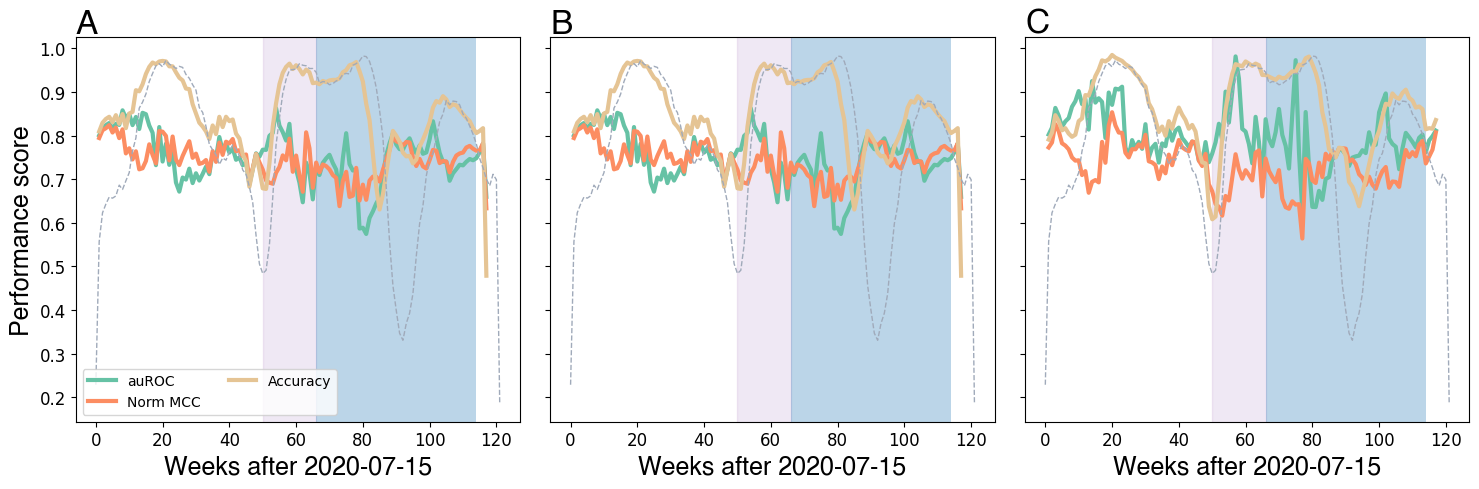

In [12]:
# Create a figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey = 'all')

# Plot data on the same plot
axs[0].plot(weeks_to_predict, ROC_by_week_naive_period, label='auROC', linewidth = 3, color = palette[0])
axs[0].plot(weeks_to_predict, norm_MCC_by_week_naive_period, label='Norm MCC', linewidth = 3, color = palette[1])
axs[0].plot(weeks_to_predict, accuracy_by_week_naive_period, label='Accuracy', linewidth = 3, color = palette[5])
axs[0].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth = 1, color = '#A0AABA', linestyle = '--')

# Plot data on the same plot
axs[1].plot(weeks_to_predict, ROC_by_week_naive_exact, label='auROC', linewidth = 3, color = palette[0])
axs[1].plot(weeks_to_predict, norm_MCC_by_week_naive_exact, label='Norm MCC', linewidth = 3, color = palette[1])
axs[1].plot(weeks_to_predict, accuracy_by_week_naive_exact, label='Accuracy', linewidth = 3, color = palette[5])
axs[1].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth = 1, color = '#A0AABA', linestyle = '--')

axs[2].plot(weeks_to_predict, ROC_by_week_naive_shifted, label='auROC', linewidth=3, color=palette[0])
axs[2].plot(weeks_to_predict, norm_MCC_by_week_naive_shifted, label='Norm MCC', linewidth = 3, color = palette[1])
axs[2].plot(weeks_to_predict, accuracy_by_week_naive_shifted, label='Accuracy', linewidth=3, color=palette[5])
axs[2].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth = 1, color = '#A0AABA', linestyle = '--')

# Add labels and legend
axs[0].set_xlabel('Weeks after 2020-07-15',**hfont,  fontsize = 18 )
axs[1].set_xlabel('Weeks after 2020-07-15',**hfont,  fontsize = 18 )
axs[2].set_xlabel('Weeks after 2020-07-15',**hfont,  fontsize = 18 )

axs[0].set_ylabel('Performance score',**hfont,  fontsize = 18)
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[1].tick_params(axis='both', which='major', labelsize=12)
axs[2].tick_params(axis='both', which='major', labelsize=12)

add_labels_to_subplots(axs, hfont, 1.01, 24)
axs[0].legend(ncol = 2, loc='lower left')

for ax in axs:
    polygon_delta = Polygon([(first_week_delta, 0), (first_week_delta, 100000), (last_week_delta, 100000), (last_week_delta, 0)],
                      alpha=0.3, color = '#cdb4db')
    ax.add_patch(polygon_delta)
    polygon_omricon = Polygon([(first_week_omricon, 0), (first_week_omricon, 100000), (last_week_omricon, 100000), (last_week_omricon, 0)],
                      alpha=0.3)
    ax.add_patch(polygon_omricon)
plt.tight_layout()

#plt.savefig(f'/Users/rem76/Documents/COVID_projections/COVID_forecasting/Graphs/Performance_naive_expanding_train_models_period_exact_shifted_test_{size_of_test_dataset}_week.png', dpi = 300)

# Full Classifier

In [13]:
new_directory = '/Users/rem76/Documents/COVID_projections/Expanding_training_set/Full_model_period_incl_NA'
os.chdir(new_directory)

In [14]:
clf_full_period = DecisionTreeClassifier( random_state=10, class_weight='balanced')

In [16]:
no_iterations = 10
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_period = 'period'  # Choose 'period', 'exact', or 'shifted'
size_of_test_dataset = 1
train_weeks_for_initial_model = 1
weeks_in_future = 3 
weight_col = 'weight'  
keep_output = True  

no_iterations_param = 100  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5, 1),
    'min_samples_split': np.arange(200, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(200, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }
weeks_to_predict = range(1, 123 - size_of_test_dataset - 3 - train_weeks_for_initial_model)

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

 MODEL TRAINING DONE ON CLUSTER

Get metrics from loaded models

In [18]:

# Initialize lists to store results
ROC_by_week_full_period = []
accuracy_by_week_full_period = []
norm_MCC_by_week_full_period = []

ROC_by_week_full_shifted = []
accuracy_by_week_full_shifted = []
norm_MCC_by_week_full_shifted = []

ROC_by_week_full_exact = []
accuracy_by_week_full_exact = []
norm_MCC_by_week_full_exact = []

size_of_test_dataset = 1

for prediction_week in weeks_to_predict:
    # Evaluate the period model
    model_name = "Full_model"
    accuracy_period, roc_auc_period, mcc_period = prepare_data_and_model(HSA_weekly_data_all, weeks_in_future, geography_column, weight_col, keep_output,'period', model_name, prediction_week, size_of_test_dataset, train_weeks_for_initial_model)
    X_train, y_train, weights_train, missing_data_train_HSA = prep_training_test_data_period(data = HSA_weekly_data_all, 
            no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1),  weeks_in_future=weeks_in_future, geography='HSA_ID', weight_col=weight_col, keep_output=keep_output)
    accuracy_by_week_full_period.append(accuracy_period)
    ROC_by_week_full_period.append(roc_auc_period)
    norm_MCC_by_week_full_period.append(mcc_period)

    # Evaluate the shifted model
    model_name = "/Users/rem76/Documents/COVID_projections/Expanding_full_model_shifted/Full_model_shifted_NA/Full_model"
    accuracy_shifted, roc_auc_shifted, mcc_shifted = prepare_data_and_model(HSA_weekly_data_all, weeks_in_future, geography_column, weight_col, keep_output,'shifted', model_name, prediction_week, size_of_test_dataset, train_weeks_for_initial_model)
    accuracy_by_week_full_shifted.append(accuracy_shifted)
    ROC_by_week_full_shifted.append(roc_auc_shifted)
    norm_MCC_by_week_full_shifted.append(mcc_shifted)

    # Evaluate the exact model
    #model_name = "/Users/rem76/Documents/COVID_projections/Expanding_full_model_exact/Full_model_e_NA/Full_model"
    #accuracy_exact, roc_auc_exact, mcc_exact = prepare_data_and_model(HSA_weekly_data_all, weeks_in_future, geography_column, weight_col, keep_output,'exact', model_name, prediction_week, size_of_test_dataset, train_weeks_for_initial_model)
    #accuracy_by_week_full_exact.append(accuracy_exact)
    #ROC_by_week_full_exact.append(roc_auc_exact)
    #norm_MCC_by_week_full_exact.append(mcc_exact)

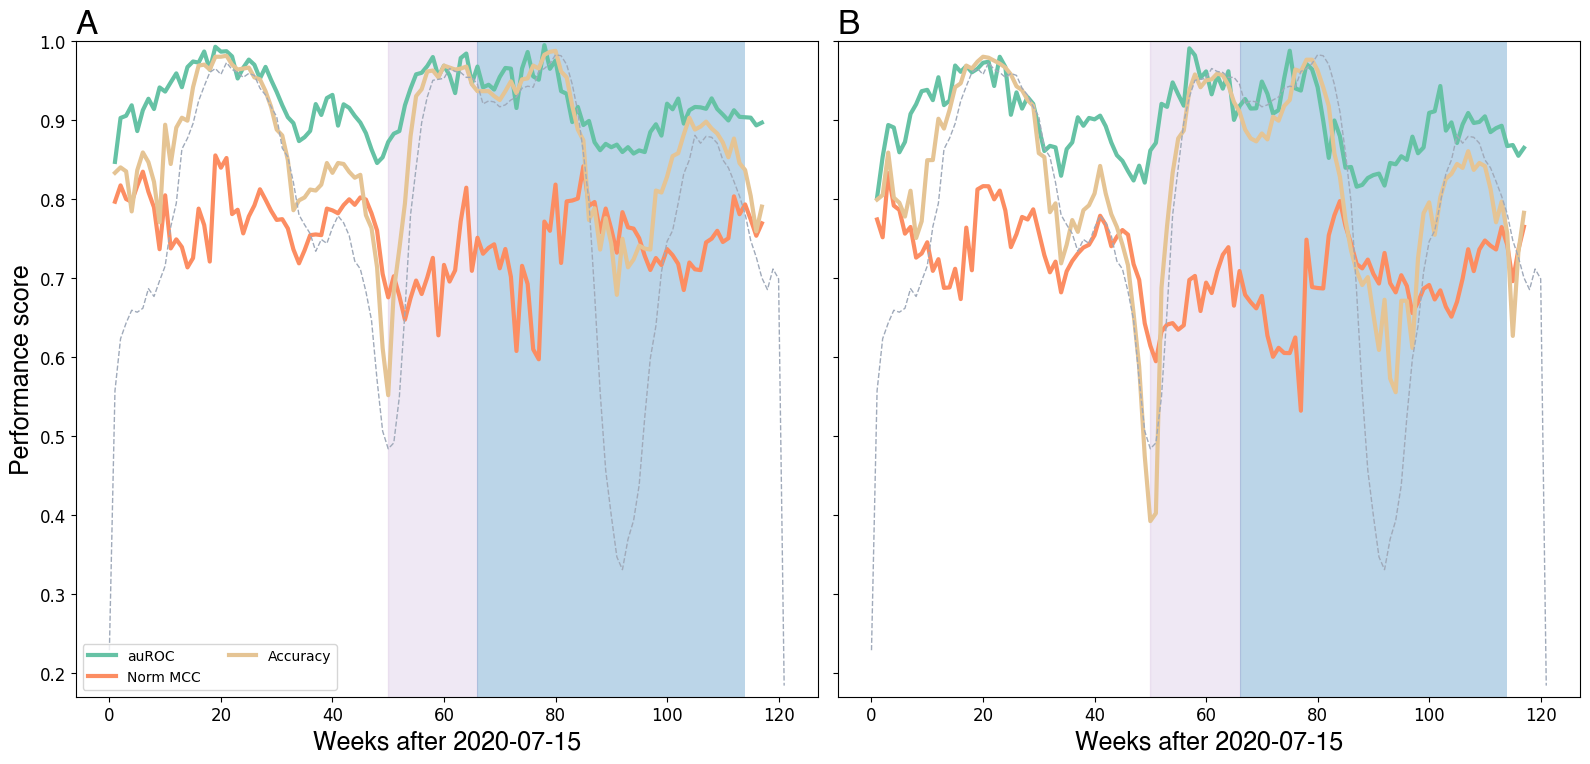

In [19]:
# Create a figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 7.5), sharey = 'all')

# Plot data on the same plot
axs[0].plot(weeks_to_predict, ROC_by_week_full_period, label='auROC', linewidth = 3, color = palette[0])
axs[0].plot(weeks_to_predict, norm_MCC_by_week_full_period, label='Norm MCC', linewidth = 3, color = palette[1])
axs[0].plot(weeks_to_predict, accuracy_by_week_full_period, label='Accuracy', linewidth = 3, color = palette[5])
axs[0].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth = 1, color = '#A0AABA', linestyle = '--')


axs[1].plot(weeks_to_predict, ROC_by_week_full_shifted, label='auROC', linewidth = 3, color = palette[0])
axs[1].plot(weeks_to_predict, norm_MCC_by_week_full_shifted, label='Norm MCC', linewidth = 3, color = palette[1])
axs[1].plot(weeks_to_predict, accuracy_by_week_full_shifted, label='Accuracy', linewidth = 3, color = palette[5])
axs[1].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth = 1, color = '#A0AABA', linestyle = '--')



# Add labels and legend
axs[0].set_xlabel('Weeks after 2020-07-15',**hfont,  fontsize = 18 )
axs[1].set_xlabel('Weeks after 2020-07-15',**hfont,  fontsize = 18 )

axs[0].set_ylabel('Performance score',**hfont,  fontsize = 18)
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[1].tick_params(axis='both', which='major', labelsize=12)

axs[0].set_ylim(0.17,1)
#add_labels_to_subplots(axs, hfont, 1.01, 24)
axs[0].legend(ncol = 2, loc='lower left')

polygon_delta = Polygon([(first_week_delta, 0), (first_week_delta, 100000), (last_week_delta, 100000), (last_week_delta, 0)],
                      alpha=0.3, color = '#cdb4db')
axs[0].add_patch(polygon_delta)
polygon_omricon = Polygon([(first_week_omricon, 0), (first_week_omricon, 100000), (last_week_omricon, 100000), (last_week_omricon, 0)],
                      alpha=0.3)
axs[0].add_patch(polygon_omricon)

polygon_delta = Polygon([(first_week_delta, 0), (first_week_delta, 100000), (last_week_delta, 100000), (last_week_delta, 0)],
                      alpha=0.3, color = '#cdb4db')
axs[1].add_patch(polygon_delta)
polygon_omricon = Polygon([(first_week_omricon, 0), (first_week_omricon, 100000), (last_week_omricon, 100000), (last_week_omricon, 0)],
                      alpha=0.3)
axs[1].add_patch(polygon_omricon)
plt.tight_layout()
add_labels_to_subplots(axs, hfont, 1.01, 24);
#plt.savefig(f'/Users/rem76/Documents/COVID_projections/COVID_forecasting/Graphs/Performance_full_expanding_train_models_period_shifted_test_{size_of_test_dataset}_week.png', dpi = 300)

Best and worst classifiers - period model

In [15]:
max_index = ROC_by_week_full_shifted.index(max(ROC_by_week_full_shifted))
best_model_week = max_index + 1 # have to add because of zero indexing
print(best_model_week)
print(ROC_by_week_full_shifted[max_index])
# Find the index of the minimum value
min_index = ROC_by_week_full_shifted.index(min(ROC_by_week_full_shifted))
worst_model_week = min_index + 1
print(worst_model_week)
print(ROC_by_week_full_shifted[min_index])

57
0.9907313997477932
1
0.8017846742657458


In [16]:
time_period = 'shifted'
Best_model = "/Users/rem76/Documents/COVID_projections/Expanding_full_model_shifted/Full_model_shifted_NA/Full_model_" + time_period + "_" + str(best_model_week) + ".sav"
Worst_model = "/Users/rem76/Documents/COVID_projections/Expanding_full_model_shifted/Full_model_shifted_NA/Full_model_" + time_period + "_" + str(worst_model_week) + ".sav"


clf_full_period_best = pickle.load(open(Best_model, 'rb'))
clf_full_period_worst = pickle.load(open(Worst_model, 'rb'))

Best_model = "Full_model_best_" + time_period + ".sav"
Worst_model = "Full_model_worst_" + time_period + ".sav"
pickle.dump(clf_full_period_best, open(Best_model, 'wb'))
pickle.dump(clf_full_period_worst, open(Worst_model, 'wb'))

# Only features used in CDC classifiers - shifted period

In [20]:
HSA_only_CDC = pd.read_csv("/Users/rem76/Documents/COVID_projections/COVID_forecasting/hsa_time_data_all_dates_CDC_features_only_incl_NA.csv")

CDC A

In [21]:
weeks_to_predict = range(1, 123 - size_of_test_dataset - 3 - train_weeks_for_initial_model)

ROC_by_week_CDC_A_period = []
accuracy_by_week_CDC_A_period = []
norm_MCC_by_week_CDC_A_period = []

ROC_by_week_CDC_A_shifted = []
accuracy_by_week_CDC_A_shifted = []
norm_MCC_by_week_CDC_A_shifted = []

size_of_test_dataset = 1
keep_output = False

for prediction_week in weeks_to_predict:
    # Evaluate the period model
    model_name = "/Users/rem76/Documents/COVID_projections/CDC_A/CDC_A_incl_NA/CDC_model"
    
    accuracy_period, roc_auc_period, mcc_period = prepare_data_and_model(HSA_weekly_data_all, weeks_in_future, geography_column, weight_col, keep_output,'period', model_name, prediction_week, size_of_test_dataset, train_weeks_for_initial_model)
    accuracy_by_week_CDC_A_period.append(accuracy_period)
    ROC_by_week_CDC_A_period.append(roc_auc_period)
    norm_MCC_by_week_CDC_A_period.append(mcc_period)

    # Evaluate the shifted model
    accuracy_shifted, roc_auc_shifted, mcc_shifted = prepare_data_and_model(HSA_weekly_data_all, weeks_in_future, geography_column, weight_col, keep_output,'shifted', model_name, prediction_week, size_of_test_dataset, train_weeks_for_initial_model)
    accuracy_by_week_CDC_A_shifted.append(accuracy_shifted)
    ROC_by_week_CDC_A_shifted.append(roc_auc_shifted)
    norm_MCC_by_week_CDC_A_shifted.append(mcc_shifted)

CDC B

In [22]:
ROC_by_week_CDC_B_period = []
accuracy_by_week_CDC_B_period = []
norm_MCC_by_week_CDC_B_period = []

ROC_by_week_CDC_B_shifted = []
accuracy_by_week_CDC_B_shifted = []
norm_MCC_by_week_CDC_B_shifted = []

size_of_test_dataset = 1
keep_output = True
for prediction_week in weeks_to_predict:
    # Evaluate the period model
    model_name = "/Users/rem76/Documents/COVID_projections/CDC_B/CDC_B_incl_NA/CDC_model"
    accuracy_period, roc_auc_period, mcc_period = prepare_data_and_model(HSA_weekly_data_all, weeks_in_future, geography_column, weight_col, keep_output,'period', model_name, prediction_week, size_of_test_dataset, train_weeks_for_initial_model)
    accuracy_by_week_CDC_B_period.append(accuracy_period)
    ROC_by_week_CDC_B_period.append(roc_auc_period)
    norm_MCC_by_week_CDC_B_period.append(mcc_period)

    # Evaluate the shifted model
    accuracy_shifted, roc_auc_shifted, mcc_shifted = prepare_data_and_model(HSA_weekly_data_all, weeks_in_future, geography_column, weight_col, keep_output,'shifted', model_name, prediction_week, size_of_test_dataset, train_weeks_for_initial_model)
    accuracy_by_week_CDC_B_shifted.append(accuracy_shifted)
    ROC_by_week_CDC_B_shifted.append(roc_auc_shifted)
    norm_MCC_by_week_CDC_B_shifted.append(mcc_shifted)

In [73]:
ROC_by_week_naive_shifted

[0.8024907144417741,
 0.8184637485212101,
 0.8636309284866291,
 0.845843545751634,
 0.8200163174090792,
 0.8326810176125246,
 0.8403241722718147,
 0.8663392786988293,
 0.8789522399111441,
 0.9022053124779821,
 0.8723086124401913,
 0.8843911917098446,
 0.8139707336365434,
 0.9249682741116751,
 0.8757931472081218,
 0.8857617792044021,
 0.8774385072094995,
 0.7947413061916879,
 0.8988607300627761,
 0.8705357142857143,
 0.9077608142493638,
 0.9058524173027991,
 0.9122448979591837,
 0.7729974160206718,
 0.7536669213139802,
 0.7898059649010644,
 0.771037037037037,
 0.785768581081081,
 0.7697599301615015,
 0.8262873171709076,
 0.7494224803643323,
 0.7726373626373626,
 0.7812685631311465,
 0.738305833282218,
 0.7821510297482838,
 0.7758761797901128,
 0.8166098636728147,
 0.7885174418604651,
 0.8116959064327485,
 0.8184616216800995,
 0.794580286603856,
 0.7851342674774332,
 0.7738079470198675,
 0.7863435129995565,
 0.7798402255639098,
 0.7427745664739885,
 0.7391316181623947,
 0.785294984247863

# Combined graph 

In [23]:
weeks_to_predict = range(0, 117)

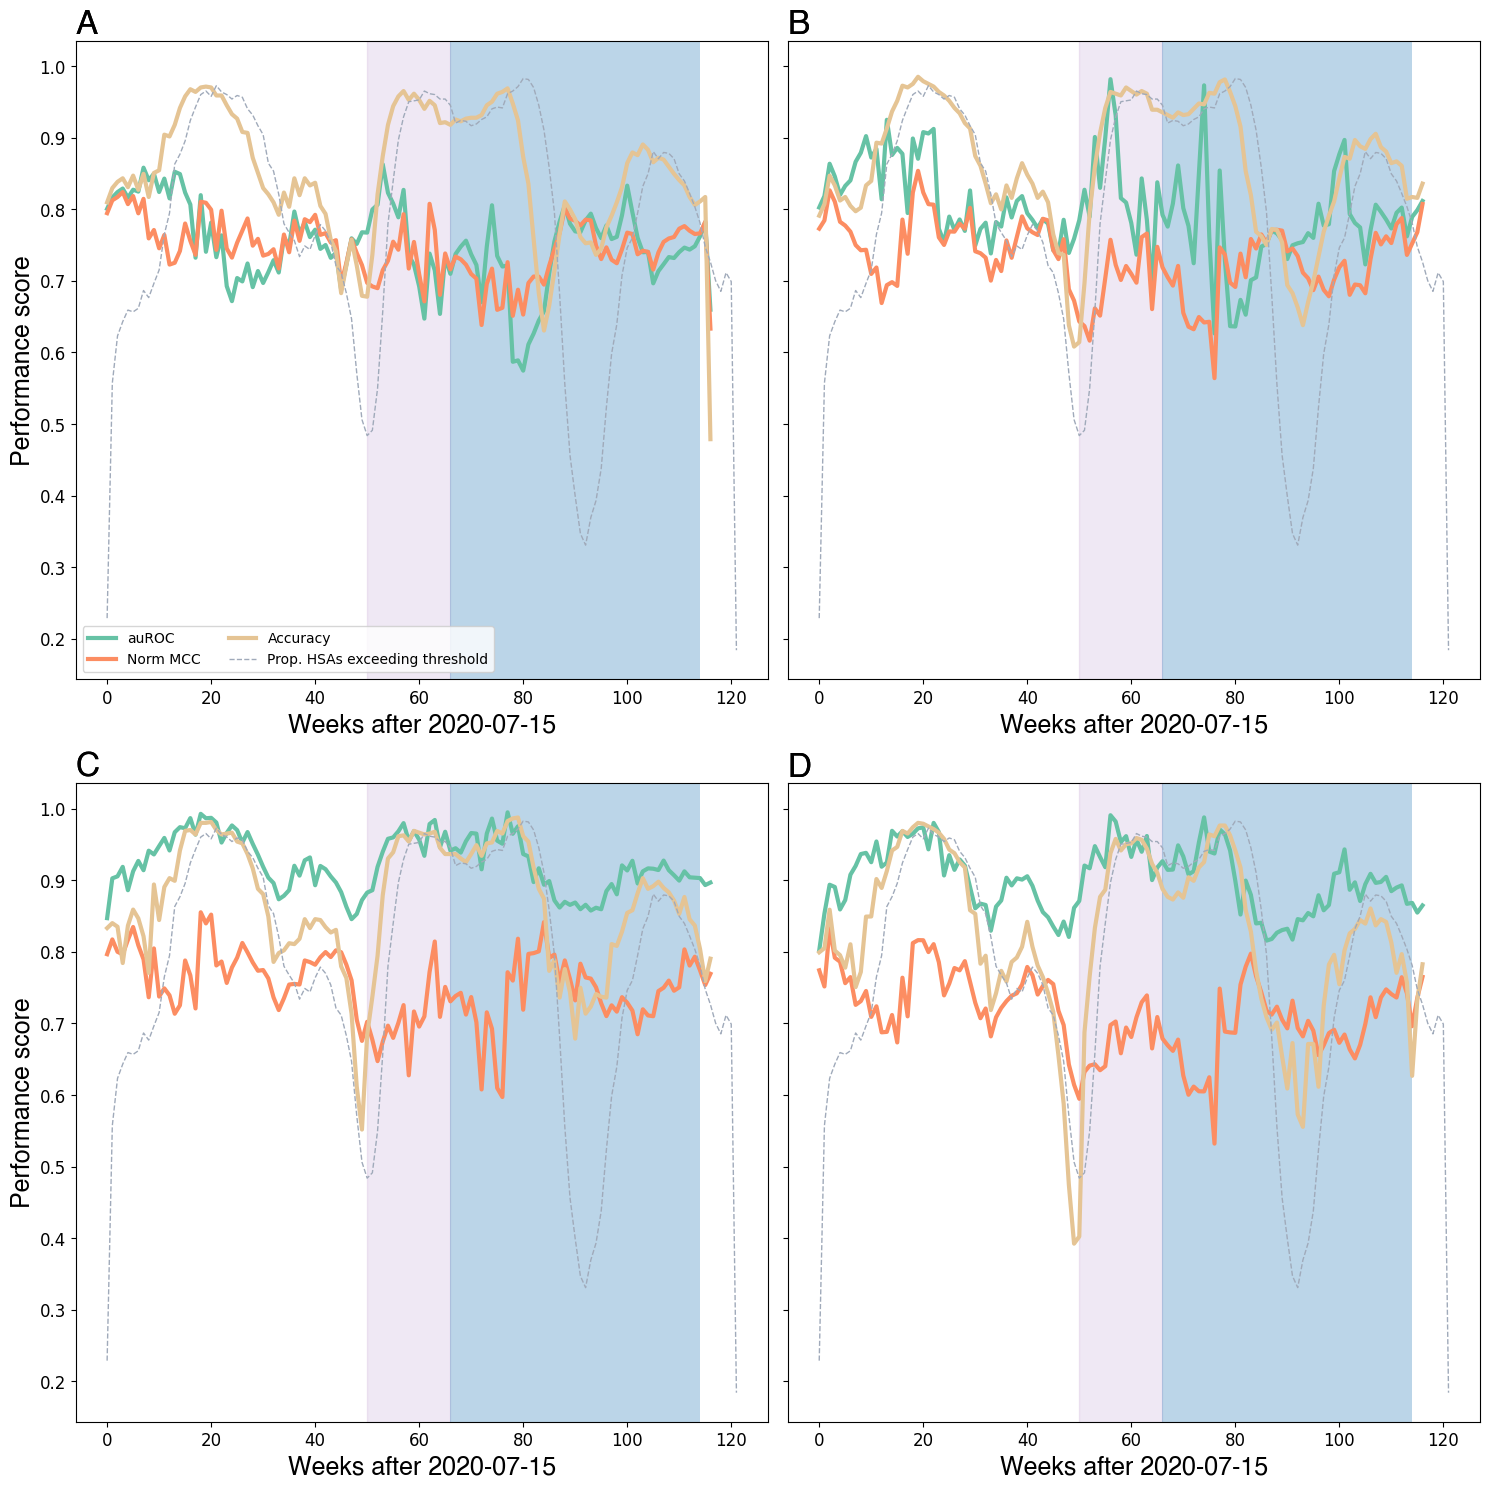

In [24]:
# Create a figure and subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15), sharey = 'all')
axs = axs.ravel()
# Plot data on the same plot
axs[0].plot(weeks_to_predict, ROC_by_week_naive_period, label='auROC', linewidth = 3, color = palette[0])
axs[0].plot(weeks_to_predict, norm_MCC_by_week_naive_period, label='Norm MCC', linewidth = 3, color = palette[1])
axs[0].plot(weeks_to_predict, accuracy_by_week_naive_period, label='Accuracy', linewidth = 3, color = palette[5])
axs[0].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth = 1, color = '#A0AABA', linestyle = '--', label = 'Prop. HSAs exceeding threshold')

axs[1].plot(weeks_to_predict, ROC_by_week_naive_shifted, label='auROC', linewidth=3, color=palette[0])
axs[1].plot(weeks_to_predict, norm_MCC_by_week_naive_shifted, label='Norm MCC', linewidth = 3, color = palette[1])
axs[1].plot(weeks_to_predict, accuracy_by_week_naive_shifted, label='Accuracy', linewidth=3, color=palette[5])
axs[1].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth = 1, color = '#A0AABA', linestyle = '--')


axs[2].plot(weeks_to_predict, ROC_by_week_full_period, label='auROC', linewidth = 3, color = palette[0])
axs[2].plot(weeks_to_predict, norm_MCC_by_week_full_period, label='Norm MCC', linewidth = 3, color = palette[1])
axs[2].plot(weeks_to_predict, accuracy_by_week_full_period, label='Accuracy', linewidth = 3, color = palette[5])
axs[2].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth = 1, color = '#A0AABA', linestyle = '--')


axs[3].plot(weeks_to_predict, ROC_by_week_full_shifted, label='auROC', linewidth = 3, color = palette[0])
axs[3].plot(weeks_to_predict, norm_MCC_by_week_full_shifted, label='Norm MCC', linewidth = 3, color = palette[1])
axs[3].plot(weeks_to_predict, accuracy_by_week_full_shifted, label='Accuracy', linewidth = 3, color = palette[5])
axs[3].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth = 1, color = '#A0AABA', linestyle = '--')

# Add labels and legend

axs[0].set_ylabel('Performance score',**hfont,  fontsize = 18)
axs[2].set_ylabel('Performance score',**hfont,  fontsize = 18)

add_labels_to_subplots(axs, hfont, 1.01, 24)
axs[0].legend(ncol = 2, loc='lower left')

plt.tight_layout()
add_labels_to_subplots(axs, hfont, 1.01, 24);

for ax in axs:
    ax.set_xlabel('Weeks after 2020-07-15',**hfont,  fontsize = 18 )
    ax.tick_params(axis='both', which='major', labelsize=12)

    polygon_delta = Polygon([(first_week_delta, 0), (first_week_delta, 100000), (last_week_delta, 100000), (last_week_delta, 0)],
                      alpha=0.3, color = '#cdb4db')
    ax.add_patch(polygon_delta)
    polygon_omricon = Polygon([(first_week_omricon, 0), (first_week_omricon, 100000), (last_week_omricon, 100000), (last_week_omricon, 0)],
                      alpha=0.3)
    ax.add_patch(polygon_omricon)
plt.tight_layout()
#plt.savefig(f'/Users/rem76/Documents/COVID_projections/COVID_forecasting/Graphs/Performance_full_and_naive_expanding_train_models_period_shifted_test_{size_of_test_dataset}_week.png', dpi = 300)

# Combined graph for immediate period - panel for each metric, line for each model type 

In [25]:
palette = ['#77CCB1', '#E78964', '#8da0cb', '#e5c494' , '#e5c494', '#FFED66']


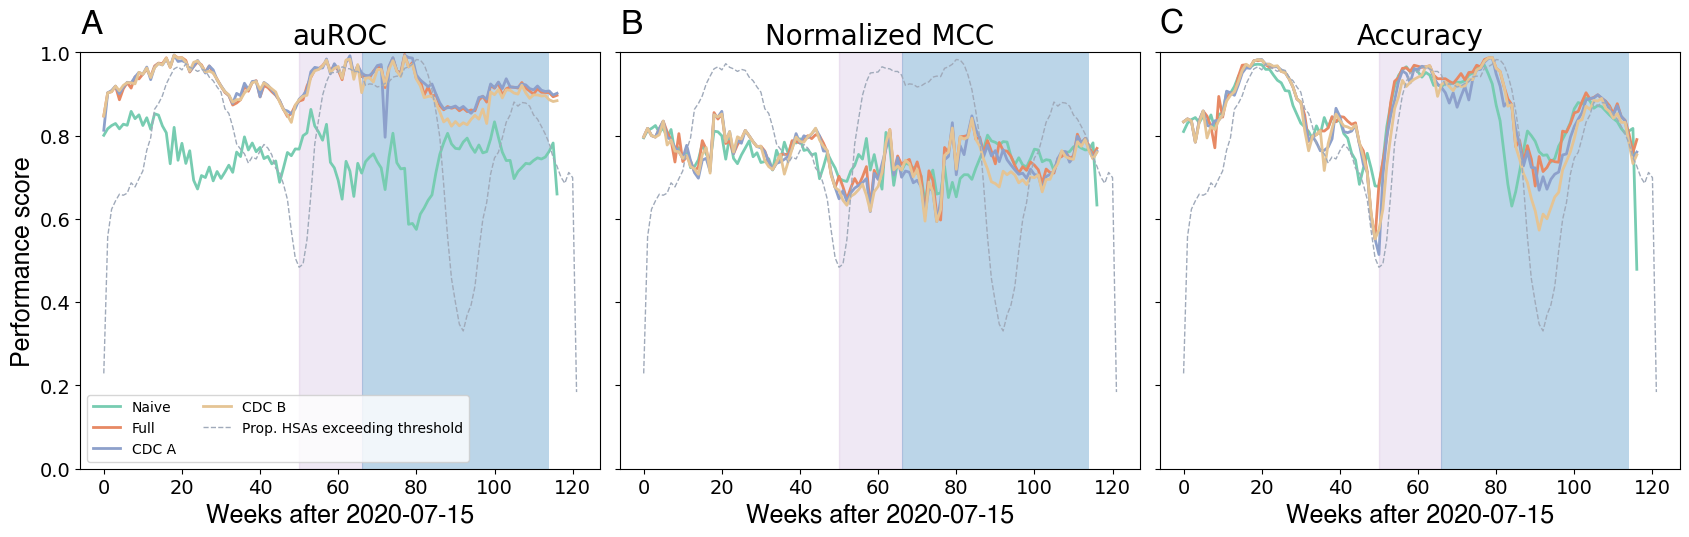

In [26]:
# Create a figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(17, 5.5), sharey = 'all')
axs = axs.ravel()
axs[0].plot(weeks_to_predict, ROC_by_week_naive_period, label='Naive', linewidth = 2, color = palette[0])
axs[0].plot(weeks_to_predict, ROC_by_week_full_period, label='Full', linewidth = 2, color = palette[1])
axs[0].plot(weeks_to_predict, ROC_by_week_CDC_A_period, label='CDC A', linewidth = 2, color = palette[2])
axs[0].plot(weeks_to_predict, ROC_by_week_CDC_B_period, label='CDC B', linewidth = 2, color = palette[3])

axs[0].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth = 1, color = '#A0AABA', linestyle = '--', label = 'Prop. HSAs exceeding threshold')
axs[0].set_title("auROC",fontsize=20)

axs[1].plot(weeks_to_predict, norm_MCC_by_week_naive_period, label='Naive', linewidth = 2, color = palette[0])
axs[1].plot(weeks_to_predict, norm_MCC_by_week_full_period, label='Full', linewidth = 2, color = palette[1])
axs[1].plot(weeks_to_predict, norm_MCC_by_week_CDC_A_period, label='CDC A', linewidth = 2, color = palette[2])
axs[1].plot(weeks_to_predict, norm_MCC_by_week_CDC_B_period, label='CDC B', linewidth = 2, color = palette[3])
axs[1].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth = 1, color = '#A0AABA', linestyle = '--')
axs[1].set_title("Normalized MCC",fontsize=20)

axs[2].plot(weeks_to_predict, accuracy_by_week_naive_period, label='Naive', linewidth = 2, color = palette[0])
axs[2].plot(weeks_to_predict, accuracy_by_week_full_period, label='Full', linewidth = 2, color = palette[1])
axs[2].plot(weeks_to_predict, accuracy_by_week_CDC_A_period, label='CDC A', linewidth = 2, color = palette[2])
axs[2].plot(weeks_to_predict, accuracy_by_week_CDC_B_period, label='CDC B', linewidth = 2, color = palette[3])
axs[2].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth = 1, color = '#A0AABA', linestyle = '--')
axs[2].set_title("Accuracy",fontsize=20)
# Add labels and legend

axs[0].set_ylabel('Performance score',**hfont,  fontsize = 18)

add_labels_to_subplots(axs, hfont, 1.01, 24)
axs[0].legend(ncol = 2, loc='lower left')

plt.tight_layout()
for ax in axs:
    ax.set_ylim(0, 1)
    ax.set_xlabel('Weeks after 2020-07-15',**hfont,  fontsize = 18 )
    ax.tick_params(axis='both', which='major', labelsize=14)

    polygon_delta = Polygon([(first_week_delta, 0), (first_week_delta, 100000), (last_week_delta, 100000), (last_week_delta, 0)],
                      alpha=0.3, color = '#cdb4db')
    ax.add_patch(polygon_delta)
    polygon_omricon = Polygon([(first_week_omricon, 0), (first_week_omricon, 100000), (last_week_omricon, 100000), (last_week_omricon, 0)],
                      alpha=0.3)
    ax.add_patch(polygon_omricon)
plt.tight_layout()
plt.savefig(f'/Users/rem76/Documents/COVID_projections/COVID_forecasting/Graphs/Performance_expanding_train_models_immediate_test_{size_of_test_dataset}_week_by_metric.png', dpi = 300)

# Combined graph for shifted period - panel for each metric, line for each model type 

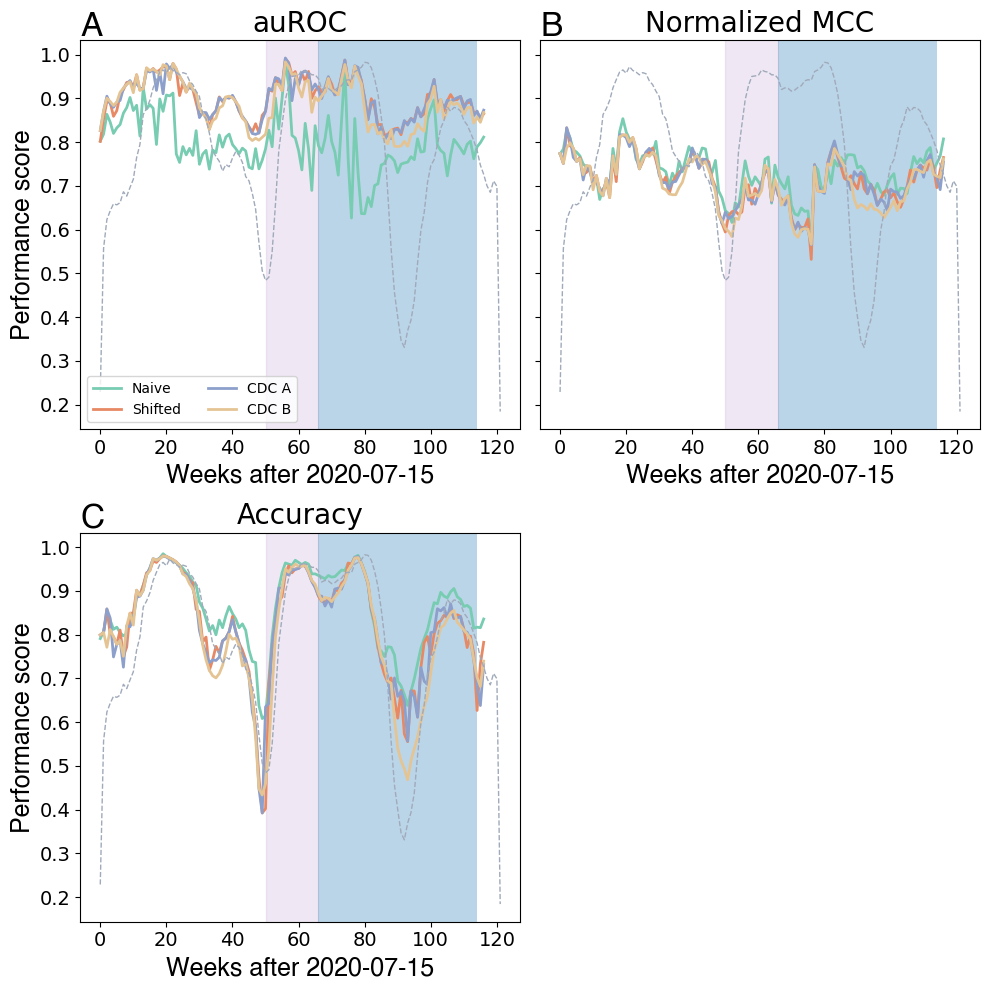

In [32]:
# Create a figure and subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), sharey = 'all')
axs = axs.ravel()
fig.delaxes(axs[3])

# Plot data on the same plot
axs[0].plot(weeks_to_predict, ROC_by_week_naive_shifted, label='Naive', linewidth=2, color=palette[0])
axs[0].plot(weeks_to_predict, ROC_by_week_full_shifted, label='Shifted', linewidth=2, color=palette[1])
axs[0].plot(weeks_to_predict, ROC_by_week_CDC_A_shifted, label='CDC A', linewidth=2, color=palette[2])
axs[0].plot(weeks_to_predict, ROC_by_week_CDC_B_shifted, label='CDC B', linewidth=2, color=palette[3])

axs[0].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth=1, color='#A0AABA', linestyle='--')#, label='Prop. HSAs exceeding threshold')
axs[0].set_title("auROC", fontsize=20)

axs[1].plot(weeks_to_predict, norm_MCC_by_week_naive_shifted, label='Naive', linewidth=2, color=palette[0])
axs[1].plot(weeks_to_predict, norm_MCC_by_week_full_shifted, label='Shifted', linewidth=2, color=palette[1])
axs[1].plot(weeks_to_predict, norm_MCC_by_week_CDC_A_shifted, label='CDC A', linewidth=2, color=palette[2])
axs[1].plot(weeks_to_predict, norm_MCC_by_week_CDC_B_shifted, label='CDC B', linewidth=2, color=palette[3])
axs[1].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth=1, color='#A0AABA', linestyle='--')
axs[1].set_title("Normalized MCC", fontsize=20)

axs[2].plot(weeks_to_predict, accuracy_by_week_naive_shifted, label='Naive', linewidth=2, color=palette[0])
axs[2].plot(weeks_to_predict, accuracy_by_week_full_shifted, label='Shifted', linewidth=2, color=palette[1])
axs[2].plot(weeks_to_predict, accuracy_by_week_CDC_A_shifted, label='CDC A', linewidth=2, color=palette[2])
axs[2].plot(weeks_to_predict, accuracy_by_week_CDC_B_shifted, label='CDC B', linewidth=2, color=palette[3])
axs[2].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth=1, color='#A0AABA', linestyle='--')
axs[2].set_title("Accuracy", fontsize=20)

# Add labels and legend

axs[0].set_ylabel('Performance score',**hfont,  fontsize = 18)
axs[2].set_ylabel('Performance score',**hfont,  fontsize = 18)

add_labels_to_subplots(axs, hfont, 1.01, 24)
axs[0].legend(ncol = 2, loc='lower left')

plt.tight_layout()
for ax in axs:
    ax.set_xlabel('Weeks after 2020-07-15',**hfont,  fontsize = 18 )
    ax.tick_params(axis='both', which='major', labelsize=14)

    polygon_delta = Polygon([(first_week_delta, 0), (first_week_delta, 100000), (last_week_delta, 100000), (last_week_delta, 0)],
                      alpha=0.3, color = '#cdb4db')
    ax.add_patch(polygon_delta)
    polygon_omricon = Polygon([(first_week_omricon, 0), (first_week_omricon, 100000), (last_week_omricon, 100000), (last_week_omricon, 0)],
                      alpha=0.3)
    ax.add_patch(polygon_omricon)
plt.tight_layout()
#plt.savefig(f'/Users/rem76/Documents/COVID_projections/COVID_forecasting/Graphs/Performance_expanding_train_models_shifted_test_{size_of_test_dataset}_week_by_metric.png', dpi = 300)

# LOOCV - naive model

In [ ]:
weeks_to_predict = range(1, 121 - 1 - 3 - 1)

ROC_by_HSA_naive = {}
accuracy_by_HSA_naive = {}
norm_MCC_by_HSA_naive = {}



for prediction_week in weeks_to_predict:
    print(prediction_week)
    ROC_by_week_naive = {}

    accuracy_by_week_naive = {}
    MCC_by_week_naive = {}
    for HSA in naive_data['HSA_ID'].unique():
        training_dataframe, testing_dataframe = LOOCV_by_HSA_dataset(naive_data, HSA, 'HSA_ID')
        if not testing_dataframe['weight'].isna().any():
            X_train_naive, y_train_naive, weights_naive, missing_data_train_HSA = prep_training_test_data(training_dataframe, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    

            X_test_naive, y_test_naive, weights_test_naive, missing_data_test_HSA = prep_training_test_data(testing_dataframe, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
            if len(X_test_naive) >= 1:
                    
                weights_naive = weights_naive[0].to_numpy()
                # no hyperparameter tuning as is the same irrespective of hyperparameters
                clf_naive = DecisionTreeClassifier( random_state=10, class_weight='balanced')
                clf_naive.fit(X_train_naive, y_train_naive, sample_weight=weights_naive)

                # Make predictions on the test set
                y_pred = clf_naive.predict(X_test_naive)
                y_pred_proba = clf_naive.predict_proba(X_test_naive)

                # Evaluate the predictive power of the model
                conf_matrix = confusion_matrix(y_test_naive, y_pred)

                accuracy_by_week_naive[HSA] = accuracy_score(y_test_naive, y_pred)
                if (sum(y_test_naive[0]) == len(y_test_naive[0])) | (sum(y_test_naive[0]) == 0):
                    ROC_by_week_naive[HSA] = None
                    MCC_by_week_naive[HSA] = None
                else:
                    ROC_by_week_naive[HSA] = roc_auc_score(y_test_naive, y_pred_proba[:, 1])
                    MCC_by_week_naive[HSA] = (matthews_corrcoef(y_test_naive, y_pred) + 1)/2




    ROC_by_HSA_naive[prediction_week] = ROC_by_week_naive
    accuracy_by_HSA_naive[prediction_week] = accuracy_by_week_naive
    norm_MCC_by_HSA_naive[prediction_week] = MCC_by_week_naive


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115


In [ ]:
ALL_METRICS_NAIVE = [ROC_by_HSA_naive, accuracy_by_HSA_naive, norm_MCC_by_HSA_naive]
labels = ['auROC', 'Accuracy', 'MCC']
labels_subplots = ['A', 'B', 'C', 'D', 'E', 'F']

ValueError: Dimensions of labels and X must be compatible

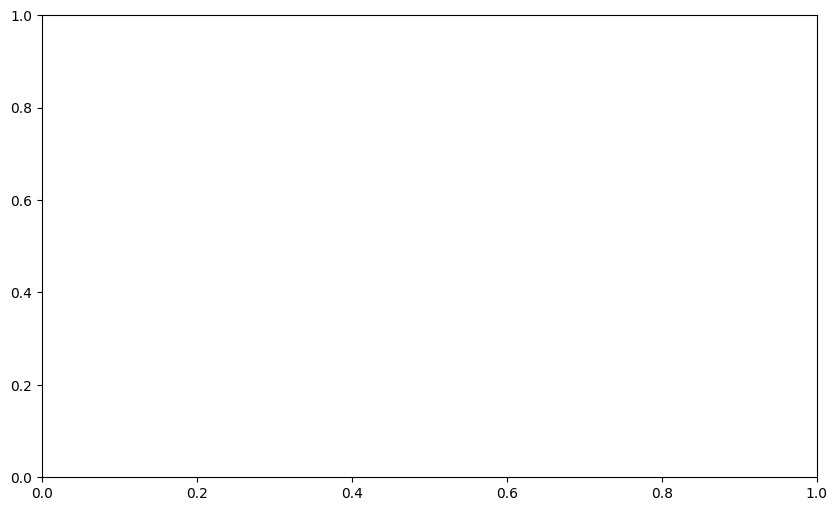

In [ ]:
for j, metric in enumerate(ALL_METRICS_NAIVE):
    fig, axs = plt.subplots(figsize=(10, 6), facecolor='w', edgecolor='k')

    all_values = []
    labels = []
    labels_ticks = [0]
    for i, prediction_week in enumerate(weeks_to_predict):
        values = metric[prediction_week].values()
        values = [float(value) for value in values if value != 'NA' and value is not None]  # Convert and filter
        
        if values:
            all_values.append(values)
            labels.append(f'Week {prediction_week}')
        if prediction_week % 5 == 0:  # Label every 5th week
                labels_ticks.append(f'{prediction_week}')
        
    # Create a combined violin and box plot
    whisker_props = dict(linewidth=1, color='#929BA0')
    box_props = dict(facecolor='#A7BBEC', edgecolor='#929BA0')
    outlier_props = dict(marker='.', markersize=2, markerfacecolor='#929BA0', markeredgecolor='#929BA0')

    axs.boxplot(all_values, labels=labels, showfliers=True, patch_artist=True,boxprops=box_props, whiskerprops=whisker_props, flierprops = outlier_props)
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Set ticks only for every 5th week
    axs.set_xticks(np.arange(0, 80, step=5))
    axs.set_xticklabels(labels_ticks, rotation=0)

    # Add labels and title
    plt.xlabel('Weeks after 2020-07-15', fontsize=18)
    plt.ylabel(ylabels[j], fontsize=18)
    axs.text(
            axs.get_xlim()[0],
            axs.get_ylim()[1] * 1.01,
            labels_subplots[j],
            fontsize=24,
            **hfont,
        )
    plt.tight_layout()
    #graph_name = '/Users/rem76/Documents/COVID_projections/COVID_forecasting/Graphs/' + 'Performance_naive_6_month_models_period_' + ylabels[j] +  '.png'
    #plt.savefig(graph_name, dpi = 300)

# LOOCV - period model

In [ ]:
ROC_by_HSA_full = {}
accuracy_by_HSA_full = {}
norm_MCC_by_HSA_full = {}


In [ ]:
weeks_to_predict = range(1, 121 - 1 - 3 - 1)




for prediction_week in weeks_to_predict:
    print(prediction_week)
    ROC_by_week_full = {}

    accuracy_by_week_full = {}
    MCC_by_week_full = {}
    for HSA in HSA_weekly_data_all['HSA_ID'].unique():
        training_dataframe, testing_dataframe = LOOCV_by_HSA_dataset(HSA_weekly_data_all, HSA, 'HSA_ID')
        if not testing_dataframe['weight'].isna().any():
            model_name_to_load = "Full_model_" + time_period + "_" + str(prediction_week) + ".sav"
            clf_full_period = pickle.load(open(model_name_to_load, 'rb'))
            #period    

            X_train_full, y_train_full, weights_full, missing_data_train_HSA = prep_training_test_data(training_dataframe, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

            X_test_full, y_test_full, weights_test_full, missing_data_test_HSA = prep_training_test_data_period(testing_dataframe, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
            if len(X_test_full) >= 1:
                weights_full = weights_full[0].to_numpy()
                clf_full_period.fit(X_train_full, y_train_full, sample_weight=weights_full)

                # Make predictions on the test set
                y_pred = clf_full_period.predict(X_test_full)
                y_pred_proba = clf_full_period.predict_proba(X_test_full)

                # Evaluate the predictive power of the model
                conf_matrix = confusion_matrix(y_test_full, y_pred)

                accuracy_by_week_full[HSA] = accuracy_score(y_test_full, y_pred)
                if (sum(y_test_full[0]) == len(y_test_full[0])) | (sum(y_test_full[0]) == 0):
                    ROC_by_week_full[HSA] = None
                    MCC_by_week_full[HSA] = None
                else:
                    ROC_by_week_full[HSA] = roc_auc_score(y_test_full, y_pred_proba[:, 1])
                    MCC_by_week_full[HSA] = (matthews_corrcoef(y_test_full, y_pred) + 1)/2




    ROC_by_HSA_full[prediction_week] = ROC_by_week_full
    accuracy_by_HSA_full[prediction_week] = accuracy_by_week_full
    norm_MCC_by_HSA_full[prediction_week] = MCC_by_week_full

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115


In [ ]:
ALL_METRICS_FULL = [ROC_by_HSA_full, accuracy_by_HSA_full, norm_MCC_by_HSA_full]
ylabels = ['auROC', 'Accuracy', 'MCC']
labels_subplots = ['A', 'B', 'C', 'D', 'E', 'F']

ValueError: Dimensions of labels and X must be compatible

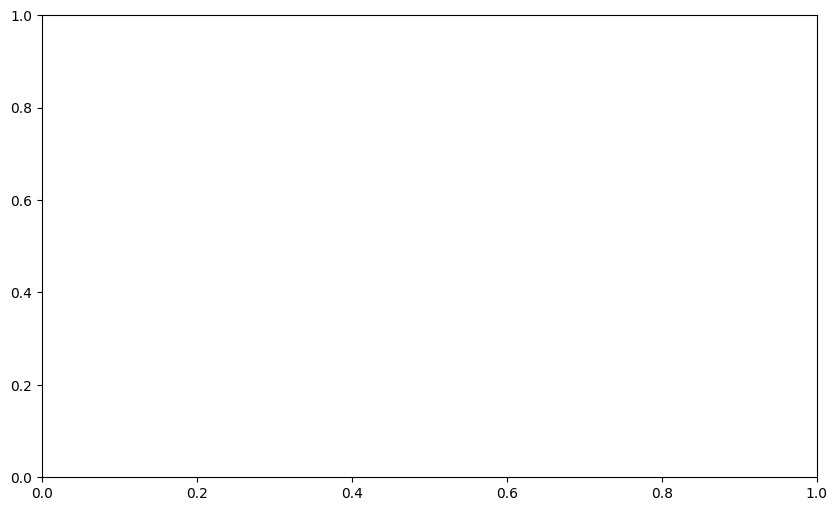

In [ ]:
weeks_to_predict = range(1,91)
for j, metric in enumerate(ALL_METRICS_FULL):
    fig, axs = plt.subplots(figsize=(10, 6), facecolor='w', edgecolor='k')

    all_values = []
    labels = []
    labels_ticks = [0]
    for i, prediction_week in enumerate(weeks_to_predict):
        values = metric[prediction_week].values()
        values = [float(value) for value in values if value != 'NA' and value is not None]  # Convert and filter
        
        if values:
            all_values.append(values)
            labels.append(f'Week {prediction_week}')
        if prediction_week % 5 == 0:  # Label every 5th week
                labels_ticks.append(f'{prediction_week}')
        
    # Create a combined violin and box plot
    whisker_props = dict(linewidth=1, color='#929BA0')
    box_props = dict(facecolor='#A7BBEC', edgecolor='#929BA0')
    outlier_props = dict(marker='.', markersize=2, markerfacecolor='#929BA0', markeredgecolor='#929BA0')

    axs.boxplot(all_values, labels=labels, showfliers=True, patch_artist=True,boxprops=box_props, whiskerprops=whisker_props, flierprops = outlier_props)
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Set ticks only for every 5th week
    axs.set_xticks(np.arange(0, 91, step=5))
    axs.set_xticklabels(labels_ticks, rotation=0)

    # Add labels and title
    plt.xlabel('Weeks after 2020-07-15', fontsize=18)
    plt.ylabel(ylabels[j], fontsize=18)
    axs.text(
            axs.get_xlim()[0],
            axs.get_ylim()[1] * 1.01,
            labels_subplots[j],
            fontsize=24,
            **hfont,
        )
    plt.tight_layout()

# No case or death data (which is now unavailable anyway)

In [11]:
os.chdir('/Users/rem76/Documents/COVID_projections/Exact_analysis/Full_model_no_cases_no_deaths')

In [19]:
HSA_weekly_data_removed = pd.read_csv('hsa_time_data_weekly_no_cases_deaths_incl_NA.csv')

In [12]:
palette = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#e5c494']


In [13]:
columns_to_remove = [col for col in HSA_weekly_data_all.columns if 'cases' in col]
HSA_weekly_data_removed = HSA_weekly_data_all.drop(columns=columns_to_remove)

columns_to_remove = [col for col in HSA_weekly_data_all.columns if 'deaths' in col]
HSA_weekly_data_removed = HSA_weekly_data_removed.drop(columns=columns_to_remove)

In [20]:
weeks_to_predict = range(1, 123 - size_of_test_dataset - 3 - train_weeks_for_initial_model)

# Initialize lists to store results
ROC_by_week_full_period_removed = []
accuracy_by_week_full_period_removed  = []
norm_MCC_by_week_full_period_removed  = []

size_of_test_dataset = 1

for prediction_week in weeks_to_predict:
    # Evaluate the period model
    model_name = "Full_model"
    accuracy_period, roc_auc_period, mcc_period = prepare_data_and_model(HSA_weekly_data_removed, weeks_in_future, geography_column, weight_col, keep_output,time_period, model_name, prediction_week, size_of_test_dataset, train_weeks_for_initial_model)
    accuracy_by_week_full_period_removed .append(accuracy_period)
    ROC_by_week_full_period_removed .append(roc_auc_period)
    norm_MCC_by_week_full_period_removed .append(mcc_period)


UnboundLocalError: cannot access local variable 'weights_train' where it is not associated with a value

ValueError: x and y must have same first dimension, but have shapes (117,) and (0,)

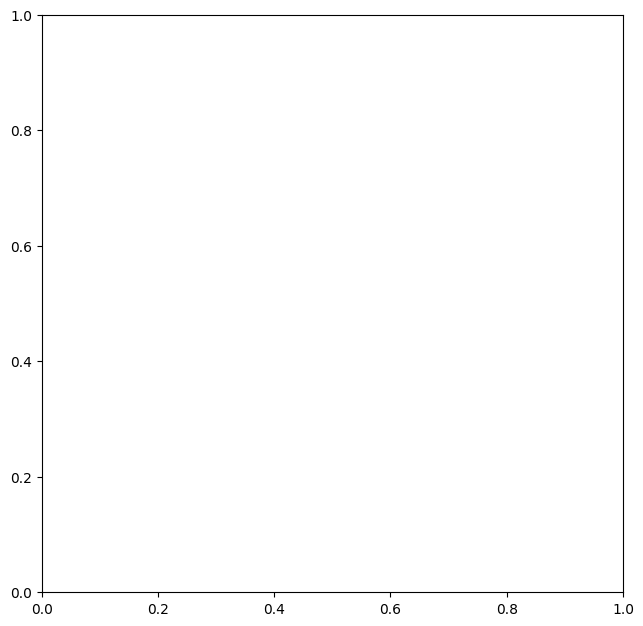

In [16]:
# Create a figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7.5, 7.5), sharey = 'all')

# Plot data on the same plot
axs.plot(weeks_to_predict, ROC_by_week_full_period_removed, label='auROC', linewidth = 3, color = palette[0])
axs.plot(weeks_to_predict, norm_MCC_by_week_full_period_removed, label='Norm MCC', linewidth = 3, color = palette[1])
axs.plot(weeks_to_predict, accuracy_by_week_full_period_removed, label='Accuracy', linewidth = 3, color = palette[5])
axs.plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth = 1, color = '#A0AABA', linestyle = '--')

axs.plot(weeks_to_predict, ROC_by_week_full_period, label='Full model: auROC', linewidth = 1.5, color = '#173A2F', linestyle = ':', alpha = 0.7)
axs.plot(weeks_to_predict, norm_MCC_by_week_full_period, label='Full model: Norm MCC', linewidth = 1.5, color = '#C83C04', linestyle = ':', alpha = 0.7)
axs.plot(weeks_to_predict, accuracy_by_week_full_period, label='Full model:Accuracy', linewidth = 1.5, color = '#835C20', linestyle = ':', alpha = 0.7)

# Add labels and legend
axs.set_xlabel('Weeks after 2020-07-15',**hfont,  fontsize = 18 )

axs.set_ylabel('Performance score',**hfont,  fontsize = 18)
axs.tick_params(axis='both', which='major', labelsize=14)

axs.set_ylim(0.17,1)
#add_labels_to_subplots(axs, hfont, 1.01, 24)
axs.legend(ncol = 2, loc='lower left')

polygon_delta = Polygon([(first_week_delta, 0), (first_week_delta, 100000), (last_week_delta, 100000), (last_week_delta, 0)],
                      alpha=0.3, color = '#cdb4db')
axs.add_patch(polygon_delta)
polygon_omricon = Polygon([(first_week_omricon, 0), (first_week_omricon, 100000), (last_week_omricon, 100000), (last_week_omricon, 0)],
                      alpha=0.3)
axs.add_patch(polygon_omricon)

plt.tight_layout()
axs.legend(ncol = 2, loc='lower left')

plt.savefig(f'/Users/rem76/Documents/COVID_projections/Exact_analysis/Graphs/Performance_model_no_cases_deaths_shifted{size_of_test_dataset}_week.png', dpi = 300)

Changes in important features 

In [98]:
feature_names=[ 'COVID-19  admissions', '\u0394 COVID-19 admissions', 'COVID-19 ICU beds', '\u0394 COVID-19 ICU beds',  'COVID-19 hospital beds', '\u0394 COVID-19 hospital beds', 'Perc. of beds with \nCOVID-19 patients', '\u0394 Perc. beds with \nCOVID-19 patients', '> 15 per 100,000 COVID-19 \npatients in hospital beds']
num_features = len(feature_names)
time_period = 'period'
# Initialize a dictionary to store feature importance counts
feature_importance_counts = {feature_name: 0 for feature_name in feature_names}

# Loop through iterations
for prediction_week in weeks_to_predict:
    # Create the training data
    X_train_full_period, y_train_full_period, weights_full_period, missing_data_train_HSA = prep_training_test_data_shifted(HSA_weekly_data_removed, no_weeks=range(prediction_week, int(prediction_week + 26) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    weights_full_period = weights_full_period[0].to_numpy()
    
    # Load and train the model 

    model_name = "/Users/rem76/Documents/COVID_projections/Expanding_full_model_shifted/Full_model_no_cases_no_deaths_incl_NA/Full_model_" + time_period + "_" + str(prediction_week) + ".sav"

    clf_full_period = pickle.load(open(model_name, 'rb'))
    clf_full_period.fit(X_train_full_period, y_train_full_period, sample_weight=weights_full_period)

    # Get feature importances for this iteration
    feature_importances = clf_full_period.feature_importances_
    
    # Update the counts for each feature
    for feature_idx, importance in enumerate(feature_importances):
        if importance > 0:
            feature_name = feature_names[feature_idx]
            feature_importance_counts[feature_name] += 1

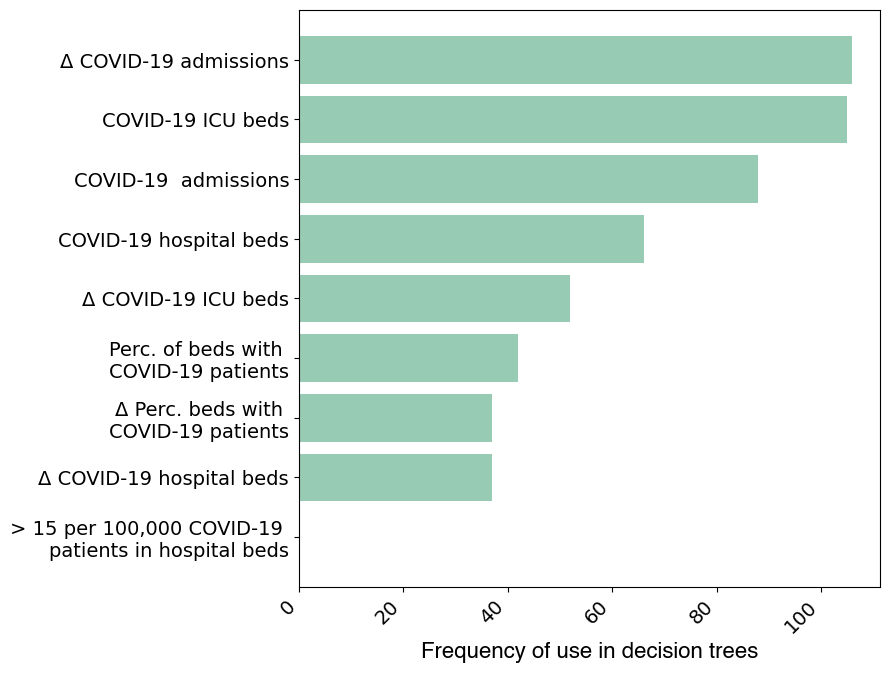

In [99]:
fig, axs = plt.subplots(1,1, figsize=(7.5, 7.5), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')

sorted_feature_importance_counts = dict(sorted(feature_importance_counts.items(), key=lambda item: item[1], reverse=False))

# Convert dict_keys to list
keys_list = list(sorted_feature_importance_counts.keys())

plt.barh(keys_list, sorted_feature_importance_counts.values(), color='#98CBB4')
plt.xlabel('Frequency of use in decision trees', fontsize = 16, **hfont)
plt.xticks(rotation=45, ha='right', fontsize = 14)
plt.yticks(fontsize=14) 
plt.savefig(f'/Users/rem76/Documents/COVID_projections/COVID_forecasting/Graphs/Important_features_model_no_cases_deaths_shifted_{size_of_test_dataset}_week.png', dpi = 300,  bbox_inches="tight")

Shap values

In [100]:
from scipy.special import softmax
import shap
shap_values_list = []

mean_shapley_values = []

size_of_test_dataset = 1
weeks_to_predict = range(1,117)
for prediction_week in weeks_to_predict:
    model_name_to_load = "/Users/rem76/Documents/COVID_projections/Expanding_full_model_shifted/Full_model_no_cases_no_deaths_incl_NA/Full_model_" + time_period + "_" + str(prediction_week) + ".sav"
    clf_full_period = pickle.load(open(model_name_to_load, 'rb'))

    print(prediction_week)

    #period    

    X_train_full, y_train_full, weights_full, missing_data_train_HSA = prep_training_test_data_period(HSA_weekly_data_removed, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_full, y_test_full, weights_test_full, missing_data_test_HSA = prep_training_test_data_period(HSA_weekly_data_removed, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_full = weights_full[0].to_numpy()
    clf_full_period.fit(X_train_full, y_train_full, sample_weight=weights_full)

    # Make predictions on the test set
    y_pred = clf_full_period.predict(X_test_full)
    y_pred_proba = clf_full_period.predict_proba(X_test_full)
        # Compute Shapley values for the current prediction
    explainer = shap.Explainer(clf_full_period)
    shap_values = explainer.shap_values(X_test_full)
    # Calculate the mean Shapley value importance

    mean_shapley_value = np.mean(shap_values[1], axis=0)
    mean_shapley_values.append(mean_shapley_value)
def print_feature_importances_shap_values(shap_values, features):
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''
    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
    # Calculates the normalized version
    importances_norm = softmax(importances)
    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116


Prediction Week: 1
Prediction Week: 2
Prediction Week: 3
Prediction Week: 4
Prediction Week: 5
Prediction Week: 6
Prediction Week: 7
Prediction Week: 8
Prediction Week: 9
Prediction Week: 10
Prediction Week: 11
Prediction Week: 12
Prediction Week: 13
Prediction Week: 14
Prediction Week: 15
Prediction Week: 16
Prediction Week: 17
Prediction Week: 18
Prediction Week: 19
Prediction Week: 20
Prediction Week: 21
Prediction Week: 22
Prediction Week: 23
Prediction Week: 24
Prediction Week: 25
Prediction Week: 26
Prediction Week: 27
Prediction Week: 28
Prediction Week: 29
Prediction Week: 30
Prediction Week: 31
Prediction Week: 32
Prediction Week: 33
Prediction Week: 34
Prediction Week: 35
Prediction Week: 36
Prediction Week: 37
Prediction Week: 38
Prediction Week: 39
Prediction Week: 40
Prediction Week: 41
Prediction Week: 42
Prediction Week: 43
Prediction Week: 44
Prediction Week: 45
Prediction Week: 46
Prediction Week: 47
Prediction Week: 48
Prediction Week: 49
Prediction Week: 50
Predictio

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


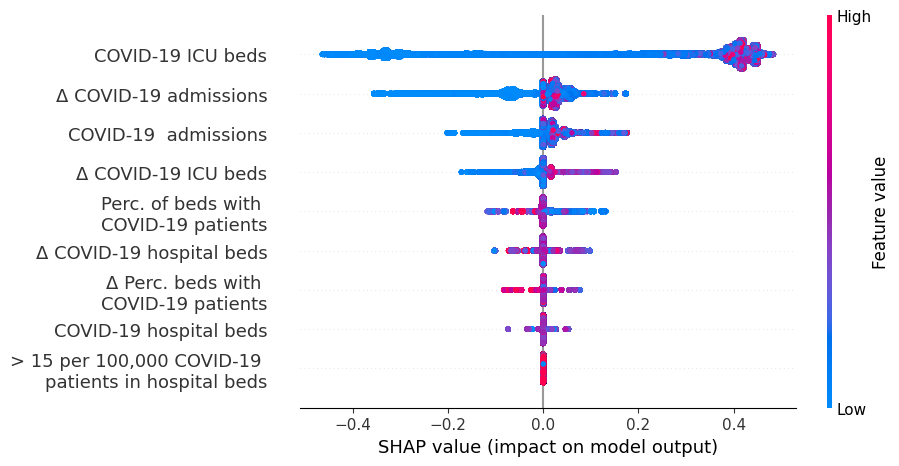

In [101]:
fig, axs = plt.subplots(1,1, figsize=(15, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')

# Initialize empty lists to store mean Shapley values and prediction weeks
mean_shapley_values = []
prediction_weeks = []

size_of_test_dataset = 1
weeks_to_predict_sample = range(1,11)

for prediction_week in weeks_to_predict:
    model_name_to_load = "/Users/rem76/Documents/COVID_projections/Full_model_no_cases_no_deaths/Full_model_" + time_period + "_" + str(prediction_week) + ".sav"
    clf_full_period = pickle.load(open(model_name_to_load, 'rb'))

    print(f"Prediction Week: {prediction_week}")
    X_train_full, y_train_full, weights_full, missing_data_train_HSA = prep_training_test_data_period(HSA_weekly_data_removed, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_full, y_test_full, weights_test_full, missing_data_test_HSA = prep_training_test_data_period(HSA_weekly_data_removed, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_full = weights_full[0].to_numpy()
    # Fit the model
    clf_full_period.fit(X_train_full, y_train_full, sample_weight=weights_full)

    X_test_full.columns = feature_names

    explainer = shap.TreeExplainer(clf_full_period)
    shap_values = explainer.shap_values(X_test_full)
    #shap.summary_plot(shap_values, features = X_test_full.columns)
    explainer = shap.Explainer(clf_full_period)
    shap_values = explainer(X_test_full)
    # Concatenate all values
    if prediction_week == weeks_to_predict[0]:
        shap_values_all = shap_values
    else:
        for feature in X_test_full.columns: 
                shap_values_all.values = np.concatenate([shap_values_all.values, shap_values.values])
                shap_values_all.base_values = np.concatenate([shap_values_all.base_values, shap_values.base_values])
                shap_values_all.data = np.concatenate([shap_values_all.data, shap_values.data])

plt.tick_params(axis='both', which='major', labelsize=10)    #shap.summary_plot(shap_values, X_test_full, plot_type="bar", feature_names= feature_names)

shap.plots.beeswarm(shap_values_all[:,:,1], max_display=14, show=False)
plt.savefig(f'/Users/rem76/Documents/COVID_projections/COVID_forecasting/Graphs/Shap_values_model_no_cases_deaths_shifted_{size_of_test_dataset}_week.png', dpi = 300)